# Method 1.freezed

In [2]:
def read_log():
    jobs = pd.read_csv(filepath_or_buffer='ml_queue.log', sep='\s+', header='infer', skiprows=[1], na_values=['UNLIMITED','Unknown','kijana','root']).dropna()

    jobs.loc[:, 'Submit'] = pd.to_datetime(jobs.loc[:, 'Submit'].copy(), errors='coerce')
    jobs.loc[:, 'Start'] = pd.to_datetime(jobs.loc[:, 'Start'].copy(), errors='coerce')
    jobs.loc[:, 'End'] = pd.to_datetime(jobs.loc[:, 'End'].copy(), errors='coerce')

    jobs.loc[:, 'NNodes'] = pd.to_numeric(jobs.loc[:, 'NNodes'].copy(), errors='coerce', downcast='integer')

    jobs.loc[:, 'Timelimit'] = jobs.loc[:, 'Timelimit'].copy().str.replace('-','day ')
    jobs.loc[:, 'Timelimit'] = pd.to_timedelta(jobs.loc[:, 'Timelimit'].copy(), errors='coerce')
    
    jobs.loc[:, 'Waited'] = (jobs.Start - jobs.Submit).values / pd.Timedelta('1h')

#     jobs = jobs[(np.abs(scipy.stats.zscore(jobs.loc[:,'Wait'].values / pd.Timedelta('1h'))) <3)]
    jobs = jobs.dropna()
    
    jobs = jobs.sort_values(by = 'Submit')
    
    return jobs

In [3]:
def sample_numerize(self, jobs, i):

    tj = this_job     = jobs.iloc[i, :].copy()
    rj = related_jobs = jobs.iloc[i - self.TIMESTEPS:i + 1, :].copy()
    s  = sample       = pd.DataFrame(index = rj.index)

    HOUR = pd.Timedelta('1 hour')
    now = tj.Submit

    s.loc[:, 'User']        = self.U_lbe.transform(rj.User)

    s.loc[:, 'Submitted']   = now - rj.Submit
    s.loc[:, 'Submitted']   = s.Submitted.values / HOUR

    s.loc[:, 'Is_queueing'] = rj.Start > tj.Submit
    s.loc[:, 'Is_queueing'] = pd.to_numeric(s.Is_queueing, errors='coerce', downcast='float')

    s.loc[:, 'NNodes']      = rj.NNodes


    s.loc[:, 'Timelimit']   = rj.Timelimit

    s.loc[:, 'Ran']         = rj.End - rj.Submit
    
    s.loc[:, 'Waited']      = rj.Waited

    s.loc[:, 'Is_running']  = np.logical_and(rj.Start < now, rj.End > now)

    s.loc[:, 'Is_complete'] = rj.End < now


    s.loc[:, ['Timelimit', 'Ran']] = s.loc[:, ['Timelimit', 'Ran']].values / HOUR

    s.loc[:, ['Is_running', 'Is_complete']]  = s.loc[:, ['Is_running', 'Is_complete']].apply(pd.to_numeric, errors='coerce', downcast='float')


    s.loc[:, 'Ran']         = s.Ran * s.Is_complete
    
    s.loc[:, 'Waited']      = s.Waited.values * np.logical_or(s.Is_running, s.Is_complete)


    U = s.User.values

    X = s.loc[:, ['Submitted', 'Is_queueing', 'NNodes', 'Timelimit', 'Waited', 'Is_running', 'Ran', 'Is_complete']].values

    y = tj.Waited

    return U, X, y

class Sampler_numerizer():
    
    def __init__(self, TIMESTEPS):
        self.TIMESTEPS = TIMESTEPS
        self.U_lbe  = sklearn.preprocessing.LabelEncoder()
    
    def fit(self, jobs):
        self.U_lbe.fit(jobs.User.values)
        return self
    
    def transform(self, jobs): 
        
        return zip(*joblib.Parallel(n_jobs=20)(joblib.delayed(sample_numerize)(self, jobs, i) for i in tnrange(self.TIMESTEPS, len(jobs), 5, desc=self.__class__.__name__)))
        
        # L = [sample_numerize(self, jobs, i) for i in range(self.TIMESTEPS, len(jobs))]
        # U, X, y = zip(*L)
        # return U, X, y

In [7]:
class Outlierremover():

    def fit(self, U, X, y):
        pd_y = pd.to_numeric(pd.Series(y))

        self.y_quantile_05 = pd_y.quantile(0.05)
        self.y_quantile_95 = pd_y.quantile(0.95)
        
        return self
        
    def transform(self, U, X, y):
        '''
        Catch: y is presumed to be 'known'.
        Reinforces the idea the ML should be 'the culmination step', not the first step.
        '''
        int_U = np.int32(U)
        float_X = np.float32(X)
        float_y = np.float32(y)

        rof_mask = np.logical_and(self.y_quantile_05 < float_y, float_y < self.y_quantile_95)
        rof_U = int_U[rof_mask]
        rof_X = float_X[rof_mask]
        rof_y = float_y[rof_mask]

        return rof_U, rof_X, rof_y

In [4]:
class Scaler_padder_reshaper():
    
    def __init__(self):
        self.X_scaler = sklearn.preprocessing.StandardScaler()
        self.y_scaler = sklearn.preprocessing.StandardScaler()
        
    def fit(self, U, X, y):
        float_X = np.float32(X)
        float_y = np.float32(y)
        
        self.X_scaler.fit(
            float_X.reshape(-1, float_X.shape[-1])
        )
        self.y_scaler.fit(
            float_y.reshape(-1, 1)
        )
        
        return self
        
    def transform(self, U, X, y):
        
        scale_X = self.X_scaler.transform(float_X.reshape(-1, float_X.shape[-1])).reshape(float_X.shape)
        scale_y = self.y_scaler.transform(float_y.reshape(-1, 1))
        
        return (int_U, scale_X, scale_y)
    
    def inverse_transform(self, yhat):
        float_yhat = np.float32(yhat)
        
        return self.y_scaler.inverse_transform(float_yhat.reshape(-1, 1)).reshape(-1)
    

In [5]:
def dropout_gru(self, units, keep_prob):
    return tf.contrib.rnn.DropoutWrapper(
        tf.contrib.cudnn_rnn.CudnnCompatibleGRUCell(units),
        input_keep_prob = keep_prob,
        output_keep_prob = keep_prob,
        state_keep_prob = keep_prob
    )

class Regressor():
    
    def graph(self, _U, _X, _y, embeddings_size = 3, keep_prob = 1.0):

        U = tf.placeholder(name="U", dtype=tf.int32, shape=(None, None))
        U_embeddings = tf.get_variable(name="U_embeddings", shape=[np.amax(_U), embeddings_size])
        U_embedded = tf.nn.embedding_lookup(U_embeddings, U, name="U_embedded")

        X = tf.placeholder(name="X", dtype=tf.float32, shape=(None, None, _X.shape[-1]))
        XU = tf.concat([X,U_embedded], axis=-1, name="XU")
        XU.set_shape([None, None, X.shape[-1] + embeddings_size])

        y = tf.placeholder(name="y", dtype=tf.float32, shape=(None, _y.shape[-1]))

        h1s, h1 = tf.nn.dynamic_rnn(
            tf.contrib.rnn.MultiRNNCell([
                tf.contrib.rnn.DropoutWrapper(
                    tf.contrib.cudnn_rnn.CudnnCompatibleGRUCell(16),
                    input_keep_prob = keep_prob,
                    output_keep_prob = keep_prob,
                    state_keep_prob = keep_prob
                ),
                tf.contrib.rnn.DropoutWrapper(
                    tf.contrib.cudnn_rnn.CudnnCompatibleGRUCell(8),
                    input_keep_prob = keep_prob,
                    output_keep_prob = keep_prob,
                    state_keep_prob = keep_prob
                )]), 
            XU, dtype=tf.float32, scope="h1")
        yhat = tf.layers.dense(h1[-1], units=1, activation=None, name="yhat")

        loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False, name="loss")
        training_op = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss, name="training_op")

        return U, X, y, yhat, training_op
    
    def fit(self, _U, _X, _y, cont, n_epochs = 100, batch_size = 256):
        tf.reset_default_graph()
        U, X, y, yhat, training_op = self.graph(_U, _X, _y, keep_prob=0.95)
        
        sess = tf.Session()
        if cont:
            tf.train.Saver().restore(sess, './ckpt')
        else:
            tqdm.write('Re-initializing variables...')
            sess.run(tf.global_variables_initializer())
        for epoch in tnrange(n_epochs * len(_X) / batch_size, desc=self.__class__.__name__):
            index = np.random.choice(range(len(_X)), batch_size, replace=False)
            sess.run(training_op, feed_dict = {U: _U[index], X: _X[index], y: _y[index]})
        tf.train.Saver().save(sess, './ckpt')
        sess.close()
        
        return self
        
    def transform(self, _U, _X, _y):
        
        tf.reset_default_graph()
        U, X, y, yhat, training_op = self.graph(_U, _X, _y, keep_prob=1.0)
        
        sess = tf.Session()
        tf.train.Saver().restore(sess, './ckpt')
        yhat_ = sess.run(yhat, feed_dict = {U: _U, X: _X, y: _y})
        sess.close()
        return yhat_

In [ ]:
class Pipeline():
    
    def __init__(self, ETs):
        self.ETs = Estimators_Transformers = ETs
      
    def fit(self, *args):
        '''Note: does not take keyworded input.'''
        for ET in self.ETs:
            args = ET.fit(*args).transform(*args)
        return self

    def transform(self, *args):
        for ET in self.ETs:
            args = ET.transform(*args)
        return args
    
    def fit_transform(self, *args):
        for ET in self.ETs:
            args = ET.fit(*args).transform(*args)
        return args

HBox(children=(IntProgress(value=0, description=u'Sampler_numerizer', max=2247), HTML(value=u'')))

<IPython.core.display.Javascript object>


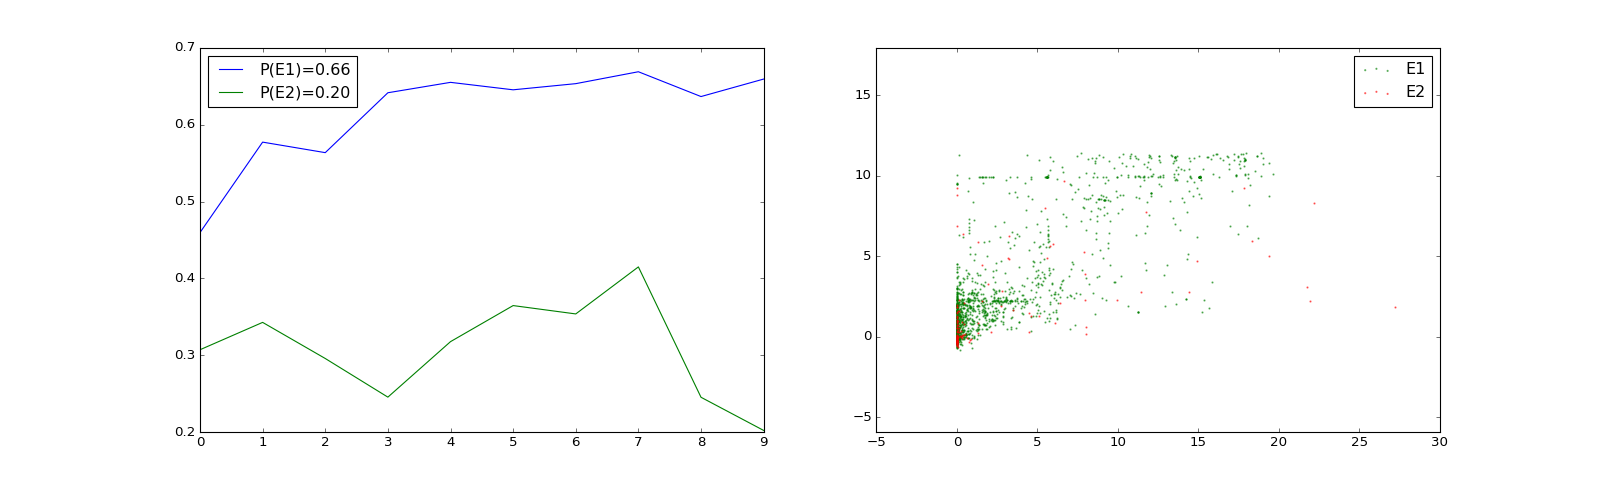

HBox(children=(IntProgress(value=0, max=10), HTML(value=u'')))

Re-initializing variables...


HBox(children=(IntProgress(value=0, description=u'Regressor', max=510), HTML(value=u'')))

INFO:tensorflow:Restoring parameters from ./ckpt


HBox(children=(IntProgress(value=0, description=u'Sampler_numerizer', max=190), HTML(value=u'')))

INFO:tensorflow:Restoring parameters from ./ckpt
INFO:tensorflow:Restoring parameters from ./ckpt


HBox(children=(IntProgress(value=0, description=u'Regressor', max=510), HTML(value=u'')))

INFO:tensorflow:Restoring parameters from ./ckpt


HBox(children=(IntProgress(value=0, description=u'Sampler_numerizer', max=190), HTML(value=u'')))

INFO:tensorflow:Restoring parameters from ./ckpt
INFO:tensorflow:Restoring parameters from ./ckpt


HBox(children=(IntProgress(value=0, description=u'Regressor', max=510), HTML(value=u'')))

INFO:tensorflow:Restoring parameters from ./ckpt


HBox(children=(IntProgress(value=0, description=u'Sampler_numerizer', max=190), HTML(value=u'')))

INFO:tensorflow:Restoring parameters from ./ckpt
INFO:tensorflow:Restoring parameters from ./ckpt


HBox(children=(IntProgress(value=0, description=u'Regressor', max=510), HTML(value=u'')))

INFO:tensorflow:Restoring parameters from ./ckpt


HBox(children=(IntProgress(value=0, description=u'Sampler_numerizer', max=190), HTML(value=u'')))

INFO:tensorflow:Restoring parameters from ./ckpt
INFO:tensorflow:Restoring parameters from ./ckpt


HBox(children=(IntProgress(value=0, description=u'Regressor', max=510), HTML(value=u'')))

INFO:tensorflow:Restoring parameters from ./ckpt


HBox(children=(IntProgress(value=0, description=u'Sampler_numerizer', max=190), HTML(value=u'')))

INFO:tensorflow:Restoring parameters from ./ckpt
INFO:tensorflow:Restoring parameters from ./ckpt


HBox(children=(IntProgress(value=0, description=u'Regressor', max=510), HTML(value=u'')))

INFO:tensorflow:Restoring parameters from ./ckpt


HBox(children=(IntProgress(value=0, description=u'Sampler_numerizer', max=190), HTML(value=u'')))

INFO:tensorflow:Restoring parameters from ./ckpt
INFO:tensorflow:Restoring parameters from ./ckpt


HBox(children=(IntProgress(value=0, description=u'Regressor', max=510), HTML(value=u'')))

INFO:tensorflow:Restoring parameters from ./ckpt


HBox(children=(IntProgress(value=0, description=u'Sampler_numerizer', max=190), HTML(value=u'')))

INFO:tensorflow:Restoring parameters from ./ckpt
INFO:tensorflow:Restoring parameters from ./ckpt


HBox(children=(IntProgress(value=0, description=u'Regressor', max=510), HTML(value=u'')))

INFO:tensorflow:Restoring parameters from ./ckpt


HBox(children=(IntProgress(value=0, description=u'Sampler_numerizer', max=190), HTML(value=u'')))

INFO:tensorflow:Restoring parameters from ./ckpt
INFO:tensorflow:Restoring parameters from ./ckpt


HBox(children=(IntProgress(value=0, description=u'Regressor', max=510), HTML(value=u'')))

INFO:tensorflow:Restoring parameters from ./ckpt


HBox(children=(IntProgress(value=0, description=u'Sampler_numerizer', max=190), HTML(value=u'')))

INFO:tensorflow:Restoring parameters from ./ckpt
INFO:tensorflow:Restoring parameters from ./ckpt


HBox(children=(IntProgress(value=0, description=u'Regressor', max=510), HTML(value=u'')))

INFO:tensorflow:Restoring parameters from ./ckpt


HBox(children=(IntProgress(value=0, description=u'Sampler_numerizer', max=190), HTML(value=u'')))

INFO:tensorflow:Restoring parameters from ./ckpt



In [6]:
jobs = read_log()

sn = Sampler_numerizer(TIMESTEPS = 50)
o  = Outlierremover()
spr = Scaler_padder_reshaper()
p = Pipeline([sn, o, spr])
r = Regressor()

p_U1, p_X1, p_y1 = p.fit_transform(jobs)

sn_U1, sn_X1, sn_y1 = sn.fit(jobs).transform(jobs.iloc[:-2000])
spr_U1, spr_X1, spr_y1 = spr.fit(sn_U1, sn_X1, sn_y1).transform(sn_U1, sn_X1, sn_y1)

# diagnostic log
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
ax2.set_aspect('equal', adjustable='datalim')
line11, line12 = [], []
for _ in tnrange(10):

    r_yhat1 = r.fit(spr_U1, spr_X1, spr_y1, cont = (_ > 0), n_epochs = 10, batch_size=32).transform(spr_U1, spr_X1, spr_y1)
    spr_yhat1 = spr.inverse_transform(r_yhat1)

    sn_U2, sn_X2, sn_y2 = sn.transform(jobs.iloc[-2000:-1000])
    spr_yhat2 = spr.inverse_transform(r.transform(*spr.transform(sn_U2, sn_X2, sn_y2)))
    
    # diagnostic log
    line11.append(sklearn.metrics.r2_score(sn_y1, spr_yhat1))
    line12.append(sklearn.metrics.r2_score(sn_y2, spr_yhat2))
    ax1.clear()
    ax1.plot(line11, label='P(E1)=%.2f'%line11[-1])
    ax1.plot(line12, label='P(E2)=%.2f'%line12[-1])
    ax1.legend(loc='best')
    ax2.clear()
    ax2.scatter(sn_y1, spr_yhat1, color='green', s=1, alpha=0.5, label='E1')
    ax2.scatter(sn_y2, spr_yhat2, color='red', s=1, alpha=0.5, label='E2')
    ax2.legend(loc='best')
    fig.canvas.draw()
    
    

In [ ]:
keras model, same as tf

In [15]:
def r2_score(ytrue, ypred): # sklearn.metrics.r2_score in tensorflow. 1 output only. 

    ytrue_mean = tf.reduce_mean(ytrue, name="ytrue_mean")
    r2_score = tf.subtract(1., tf.truediv(tf.reduce_mean((ytrue - ypred) ** 2), tf.reduce_mean((ytrue - ytrue_mean) ** 2)), name="r2_score")
    return r2_score

class TqdmProgBar(keras.callbacks.Callback):
    '''features:
    1. tqdm ETA bar
    2. logs[field] plotted in fig
    '''
    
    def __init__(self, n_epochs, fields): 
        self.n_epochs = n_epochs
        self.fields = fields
        
        self.fields_history = dict((field, []) for field in fields)
        self.fig, self.ax = plt.subplots(1, 1)
        
    def on_train_begin(self, logs):
        self.pbar = tqdm_notebook(total=self.n_epochs, leave=False)
        
    def on_train_end(self, logs):
        self.pbar.close()
        
    def on_epoch_end(self, epoch, logs, log_interval = 40):
        if epoch % log_interval == 0:
            self.pbar.update(log_interval)

            for field in self.fields:
                self.fields_history[field].append(logs[field])

            self.ax.clear()
            for field in self.fields:
                self.ax.plot(self.fields_history[field], label="%s=%.2f" %(field, self.fields_history[field][-1]))
            self.ax.legend(loc='best')
            self.fig.canvas.draw()
        

class Regressor2():
    
    def fit(self, _U, _X, _y, cont, keep_prob, n_epochs, batch_size, embeddings_size = 3):
        
        if not cont:        
            U = keras.layers.Input(shape=(_U.shape[-1],))
            X = keras.layers.Input(shape=(_X.shape[-2], _X.shape[-1]))
            y = keras.layers.Input(shape=(_y.shape[-1],))

            U_embedded = keras.layers.Embedding(input_dim=np.amax(_U), output_dim=embeddings_size)(U)

            UX = keras.layers.Concatenate(axis=-1)([U_embedded,X])

            h = keras.layers.CuDNNGRU(units=4, return_sequences=False)(UX)
            yhat = keras.layers.Dense(units=1, activation=None)(h)

            self.G = keras.models.Model(inputs=[U, X], outputs=[yhat])
            self.G.compile(loss='mse', optimizer='adam', metrics=[r2_score])
        
        self.G.fit(
            [_U, _X], [_y], 
            validation_split=0.2, batch_size=batch_size, shuffle=True, epochs=n_epochs, verbose=0, 
            callbacks=[TqdmProgBar(n_epochs = n_epochs, fields = ['r2_score', 'val_r2_score'])]
        )
        return self
        
    def transform(self, _U, _X, _y):
        _yhat = self.G.predict([_U, _X])
        return _yhat

HBox(children=(IntProgress(value=0, description=u'Sampler_intelliremover_numerizer', max=5000), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'Sampler_intelliremover_numerizer', max=1000), HTML(value=u'')))

<IPython.core.display.Javascript object>


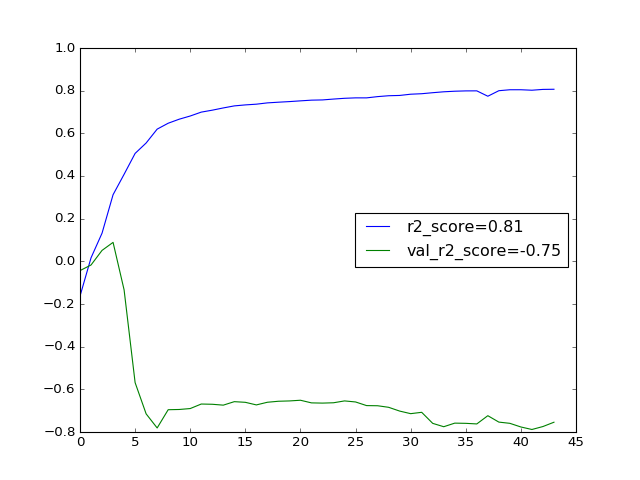

HBox(children=(IntProgress(value=0, max=8000), HTML(value=u'')))

KeyboardInterrupt: 

Exception in thread Thread-20:
Traceback (most recent call last):
  File "/usr/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/usr/local/lib/python2.7/dist-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



In [17]:
jobs = read_log()

sin = Sampler_intelliremover_numerizer(TIMESTEPS = 100)
o  = Outlierremover()
spr = Scaler_padder_reshaper()
p = Pipeline([sin, o, spr])
r = Regressor2()

_, (o_U1, o_X1, o_y1), (p_U1, p_X1, p_y1) = p.fit_transforms(jobs.iloc[np.r_[:5000]])
_, (o_U2, o_X2, o_y2), (p_U2, p_X2, p_y2) = p.transforms(jobs.iloc[5000:6000])

r.fit(p_U1, p_X1, p_y1, cont = False, keep_prob=.7, n_epochs = 8000, batch_size=1024)

In [ ]:
the eventual version of method1.

# Method 1

In [2]:
def read_log():
    jobs = pd.read_csv(filepath_or_buffer='ml_queue.log', sep='\s+', header='infer', skiprows=[1], na_values=['UNLIMITED','Unknown','kijana','root','crabb','ericfadel']).dropna()

    jobs.loc[:, 'Submit'] = pd.to_datetime(jobs.loc[:, 'Submit'].copy(), errors='coerce')
    jobs.loc[:, 'Start'] = pd.to_datetime(jobs.loc[:, 'Start'].copy(), errors='coerce')
    jobs.loc[:, 'End'] = pd.to_datetime(jobs.loc[:, 'End'].copy(), errors='coerce')

    jobs.loc[:, 'NNodes'] = pd.to_numeric(jobs.loc[:, 'NNodes'].copy(), errors='coerce', downcast='integer')

    jobs.loc[:, 'Timelimit'] = jobs.loc[:, 'Timelimit'].copy().str.replace('-','day ')
    jobs.loc[:, 'Timelimit'] = pd.to_timedelta(jobs.loc[:, 'Timelimit'].copy(), errors='coerce')
    
    jobs.loc[:, 'Waited'] = (jobs.Start - jobs.Submit).values / pd.Timedelta('1h')

#     jobs = jobs[(np.abs(scipy.stats.zscore(jobs.loc[:,'Wait'].values / pd.Timedelta('1h'))) <3)]
    jobs = jobs.dropna()
    
    jobs = jobs.sort_values(by = 'Submit')
    
    return jobs

In [3]:
def sample_intelliremove_numerize(self, jobs, i):

    # sample
    
    tj = this_job     = jobs.iloc[i, :].copy()
    rj = related_jobs = jobs.iloc[i - self.TIMESTEPS:i + 1, :].copy()
    s  = sample       = pd.DataFrame(index = rj.index)

    HOUR = pd.Timedelta('1 hour')
    now = tj.Submit
    
    
    # intelliremove i) i < self.TIMESTEPS, ii) some jobs may finish after now but are truncated, iii) available cores > nnodes
    
    if i < self.TIMESTEPS:
        return None
    
    if now < jobs.End.min():
        return None
    
    trj = true_related_jobs = jobs.loc[np.logical_and(jobs.Submit < now, jobs.Start > now)]
    on  = occupied_nodes    = trj.NNodes.sum()
    if on < 31:
        return None
    
    
    # numerize

    s.loc[:, 'User']        = self.U_lbe.transform(rj.User)

    s.loc[:, 'Submitted']   = now - rj.Submit
    s.loc[:, 'Submitted']   = s.Submitted.values / HOUR

    s.loc[:, 'Is_queueing'] = rj.Start > tj.Submit
    s.loc[:, 'Is_queueing'] = pd.to_numeric(s.Is_queueing, errors='coerce', downcast='float')

    s.loc[:, 'NNodes']      = rj.NNodes


    s.loc[:, 'Timelimit']   = rj.Timelimit

    s.loc[:, 'Ran']         = rj.End - rj.Submit
    
    s.loc[:, 'Waited']      = rj.Waited

    s.loc[:, 'Is_running']  = np.logical_and(rj.Start < now, rj.End > now)

    s.loc[:, 'Is_complete'] = rj.End < now


    s.loc[:, ['Timelimit', 'Ran']] = s.loc[:, ['Timelimit', 'Ran']].values / HOUR

    s.loc[:, ['Is_running', 'Is_complete']]  = s.loc[:, ['Is_running', 'Is_complete']].apply(pd.to_numeric, errors='coerce', downcast='float')


    s.loc[:, 'Ran']         = s.Ran * s.Is_complete
    
    s.loc[:, 'Waited']      = s.Waited.values * np.logical_or(s.Is_running, s.Is_complete)


    U = s.User.values

    X = s.loc[:, ['Submitted', 'Is_queueing', 'NNodes', 'Timelimit', 'Waited', 'Is_running', 'Ran', 'Is_complete']].values

    y = tj.Waited

    return U, X, y

class Sampler_intelliremover_numerizer():
    
    def __init__(self, TIMESTEPS):
        self.TIMESTEPS = TIMESTEPS
        self.U_lbe  = sklearn.preprocessing.LabelEncoder()
    
    def fit(self, jobs):
        self.U_lbe.fit(jobs.User.values)
        return self
    
    def transform(self, jobs): 
        L = joblib.Parallel(n_jobs=20)(joblib.delayed(sample_intelliremove_numerize)(self, jobs, i) 
                                               for i in tnrange(0, len(jobs), 1, desc=self.__class__.__name__))
        L = [_ for _ in L if _]
        U, X, y = zip(*L)
        return U, X, y

In [4]:
class Outlierremover():

    def fit(self, U, X, y):
        pd_y = pd.to_numeric(pd.Series(y))

        self.y_quantile_05 = pd_y.quantile(0.05)
        self.y_quantile_95 = pd_y.quantile(0.95)
        
        return self
        
    def transform(self, U, X, y):
        '''
        Catch: y is presumed to be 'known'.
        Reinforces the idea the ML should be 'the culmination step', not the first step.
        '''
        int_U = np.int32(U)
        float_X = np.float32(X)
        float_y = np.float32(y)

        rof_mask = np.logical_and(self.y_quantile_05 < float_y, float_y < self.y_quantile_95)
        rof_U = int_U[rof_mask]
        rof_X = float_X[rof_mask]
        rof_y = float_y[rof_mask]

        return rof_U, rof_X, rof_y

In [5]:
class Scaler_padder_reshaper():
    
    def __init__(self):
        self.X_scaler = sklearn.preprocessing.StandardScaler()
        self.y_scaler = sklearn.preprocessing.StandardScaler()
        
    def fit(self, U, X, y):
        
        self.X_scaler.fit(
            X.reshape(-1, X.shape[-1])
        )
        self.y_scaler.fit(
            y.reshape(-1, 1)
        )
        
        return self
        
    def transform(self, U, X, y):
        
        scale_X = self.X_scaler.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
        scale_y = self.y_scaler.transform(y.reshape(-1, 1))
        
        return U, scale_X, scale_y
    
    def inverse_transform(self, yhat):
        float_yhat = np.float32(yhat)
        
        return self.y_scaler.inverse_transform(float_yhat.reshape(-1, 1)).reshape(-1)
    

In [6]:
class Regressor():
    
    def graph(self, _U, _X, _y, keep_prob, embeddings_size = 3):

        U = tf.placeholder(name="U", dtype=tf.int32, shape=(None, None))
        U_embeddings = tf.get_variable(name="U_embeddings", shape=[np.amax(_U), embeddings_size])
        U_embedded = tf.nn.embedding_lookup(U_embeddings, U, name="U_embedded")

        X = tf.placeholder(name="X", dtype=tf.float32, shape=(None, None, _X.shape[-1]))
        XU = tf.concat([X,U_embedded], axis=-1, name="XU")
        XU.set_shape([None, None, X.shape[-1] + embeddings_size])

        y = tf.placeholder(name="y", dtype=tf.float32, shape=(None, _y.shape[-1]))

        h1s, h1 = tf.nn.dynamic_rnn(
            tf.contrib.rnn.MultiRNNCell([
                tf.contrib.rnn.DropoutWrapper(
                    tf.contrib.cudnn_rnn.CudnnCompatibleGRUCell(1),
                    input_keep_prob = 1,
                    output_keep_prob = keep_prob,
                    state_keep_prob = 1
                )]), 
            XU, dtype=tf.float32, scope="h1")
        yhat = tf.layers.dense(h1[-1], units=1, activation=None, name="yhat")

        loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False, name="loss")
        training_op = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss, name="training_op")

        return U, X, y, yhat, training_op
    
    def fit(self, _U, _X, _y, cont, keep_prob, n_epochs = 100, batch_size = 256):
        tf.reset_default_graph()
        U, X, y, yhat, training_op = self.graph(_U, _X, _y, keep_prob = keep_prob)
        
        sess = tf.Session()
        if cont:
            tf.train.Saver().restore(sess, './ckpt')
        else:
            tqdm.write('Re-initializing variables...')
            sess.run(tf.global_variables_initializer())
        for epoch in tnrange(n_epochs * len(_X) / batch_size, desc=self.__class__.__name__):
            index = np.random.choice(range(len(_X)), batch_size, replace = False)
            sess.run(training_op, feed_dict = {U: _U[index], X: _X[index], y: _y[index]})
        tf.train.Saver().save(sess, './ckpt')
        sess.close()
        
        return self
        
    def transform(self, _U, _X, _y):
        
        tf.reset_default_graph()
        U, X, y, yhat, training_op = self.graph(_U, _X, _y, keep_prob = 1.0)
        
        sess = tf.Session()
        tf.train.Saver().restore(sess, './ckpt')
        yhat_ = sess.run(yhat, feed_dict = {U: _U, X: _X, y: _y})
        sess.close()
        return yhat_

In [7]:
class Pipeline():
    
    def __init__(self, ETs):
        self.ETs = Estimators_Transformers = ETs
      
    def fit(self, *args):
        '''Note: does not take keyworded input.'''
        for ET in self.ETs:
            args = ET.fit(*args).transform(*args)
        return self

    def transform(self, *args):
        for ET in self.ETs:
            args = ET.transform(*args)
        return args
    
    def transforms(self, *args):
        ET_s = []
        for ET in self.ETs:
            args = ET.transform(*args)
            ET_s.append(args)
        return ET_s
    
    def fit_transform(self, *args):
        for ET in self.ETs:
            args = ET.fit(*args).transform(*args)
        return args
    
    def fit_transforms(self, *args):
        ET_s = []
        for ET in self.ETs:
            args = ET.fit(*args).transform(*args)
            ET_s.append(args)
        return ET_s

In [ ]:
jobs = read_log()

sin = Sampler_intelliremover_numerizer(TIMESTEPS = 250)
o  = Outlierremover()
spr = Scaler_padder_reshaper()
p = Pipeline([sin, o, spr])
r = Regressor()

_, (o_U1, o_X1, o_y1), (p_U1, p_X1, p_y1) = p.fit_transforms(jobs.iloc[np.r_[:5000]])
_, (o_U2, o_X2, o_y2), (p_U2, p_X2, p_y2) = p.transforms(jobs.iloc[5000:6000])

# diagnostic log
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
ax2.set_aspect('equal', adjustable='datalim')
line11, line12 = [], []

for _ in tnrange(40):
    
    r.fit(p_U1, p_X1, p_y1, cont = (_ > 0), keep_prob=.7, n_epochs = 10, batch_size=256)

    spr_yhat1 = spr.inverse_transform(r.fit(p_U1, p_X1, p_y1, cont = (_ > 0), keep_prob=.7, n_epochs = 10, batch_size=256).transform(p_U1, p_X1, p_y1))
    spr_yhat2 = spr.inverse_transform(r.transform(p_U2, p_X2, p_y2))
    
    # diagnostic log
    line11.append(sklearn.metrics.r2_score(o_y1, spr_yhat1))
    line12.append(sklearn.metrics.r2_score(o_y2, spr_yhat2))
    ax1.clear()
    ax1.plot(line11, label='P(E1)=%.2f'%line11[-1])
    ax1.plot(line12, label='P(E2)=%.2f'%line12[-1])
    ax1.legend(loc='best')
    ax2.clear()
    ax2.scatter(o_y1, spr_yhat1, color='green', s=1, alpha=0.5, label='E1')
    ax2.scatter(o_y2, spr_yhat2, color='red', s=1, alpha=0.5, label='E2')
    ax2.legend(loc='best')
    fig.canvas.draw()
    
    